# UTSA CS 4973/5483: Assignment-3

Spring 2021


**Perez - Aaron- tle728**

**Sparse Feature Point Correspondence works but the points are not fully cleaned and leading to issues**





## Learning Objectives

*   Epipolar Geometry
*   Triangulation
*   Sparse 3D Reconstruction

# Overview

Consider that you are given two stereo images. The end goal is to perform **Sparse 3D Reconstruction using Epipolar Geometry**. Following is the overview of the sparse 3D reconstruction process:


1.   Given two stereo images, find sparse feature point correspondences ( > 8 ).
2.   Use these correspondences to estimate the Fundamental Matrix (F) using the 8-Point Algorithm.
3.   Intrinsic matrices establish the relationship between the image and camera coordinates. These matrices are fixed for a given camera. Calibration is performed once using traditional checkerboard pattern techniques to obtain Intrinsic Matrix (K).
4.   Calculate the Essential Matrix (E) using the the fundamental matrix (F) and the camera intrinsic matrices (K1 & K2).
5.   To align the two camera views, the extrinsic matrix of the first camera (extr1) is considered to be Identity. The extrinsic matrix of the second camera (extr2) establishes the transformation between the two camera cameras.
6.   extr1 -> rotation (R1) = Identity, translation (T1) = zero. Use extr1 and K1 to obtain the projection matrix of the first camera (P1).
7.   extr2 -> Use the Essential matrix (E) to predict the extrinsic matrix of the second camera (extr2). There will be 4 estimates of which the one for which most of the projected 3D points are in front of both cameras. Use this extrinsic matrix to obtain the projection matrix of the second camera (P2).
8.   The camera projection matrices (P1 & P2) can be decomposed into the rotation matrices (R1 & R2) and the camera translation vectors (T1 & T2).
9.   Use the projection matrices P1 & P2 and given points to perform triangulation and obtain the sparse 3D reconstruction of the image.
10.   Validate the sparse 3D reconstruction by computing the reprojection error.


In order to obtain a depth value for the entire image (almost all pixels) we need to perform **Dense 3D Reconstruction using Stereo Rectification -- out of scope of this assignment**. Following is the overview of the dense 3D reconstruction process:

1.   The steps 1-8 mentioned above are followed to obtain these values -- Fundamental matric (F), Essential matrix (E), projection matrices (P1 & P2), rotation matrices (R1 & R2), translation vectors (T1 & T2), intrinsic matrices (K1 & K2).
2.   Perform Stereo Rectification to align both the images in a way that the epipolar lines in both the images are horizontal lines.
3.   Once the images are rectified, we select every pixel in the image-1 and perform a linear search for the corresponding pixel in image-2 on this horizontal epipolar line.
4.   We obtain correspondences for each and every pixel which can be used to compute the disparity map between the two images.
5.   Use the disparity map to compute the depth map, which is the dense 3D reconstruction of the two stereo images.


# Sparse 3D Reconstruction

In [136]:
# Add your imports here
import cv2
import matplotlib.pylab as plt
from google.colab.patches import cv2_imshow # for image display
import numpy as np
import scipy.optimize
from scipy import linalg
from scipy.linalg import null_space
import plotly.express as px
from math import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Base path where you should have all input data/images. Use this while reading.
# This is the path that will be used by the TA - if you don't have this properly, the TA will not accept the submission.
basePath = "/content/drive/My Drive/Colab Notebooks/Computer Vision/images/"

## Sparse Feature Point Correspondence
(20 points)

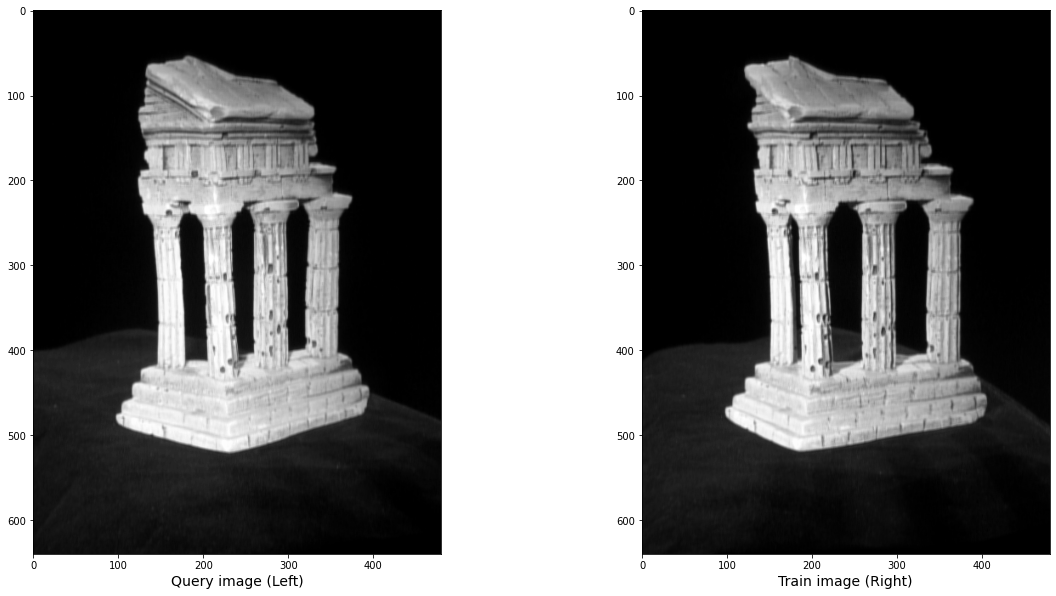

In [59]:
# Read the two images I1 & I2 and convert them to grayscale
# Plot the two images next to each other as subplots with the size of the entire figure as 20x10

I1 = cv2.imread(basePath+'stereo_image_1.png')
I2 = cv2.imread(basePath+'stereo_image_2.png')
gray_img1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
gray_img2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# Query Image LEFT
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(20,10))
ax1.imshow(gray_img1, cmap="gray")
ax1.set_xlabel("Query image (Left)", fontsize=14)
# Train Image RIGHT
ax2.imshow(gray_img2, cmap="gray")
ax2.set_xlabel("Train image (Right)", fontsize=14)

plt.show()

In [76]:
# Funcs

def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create(nfeatures=10000)
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches



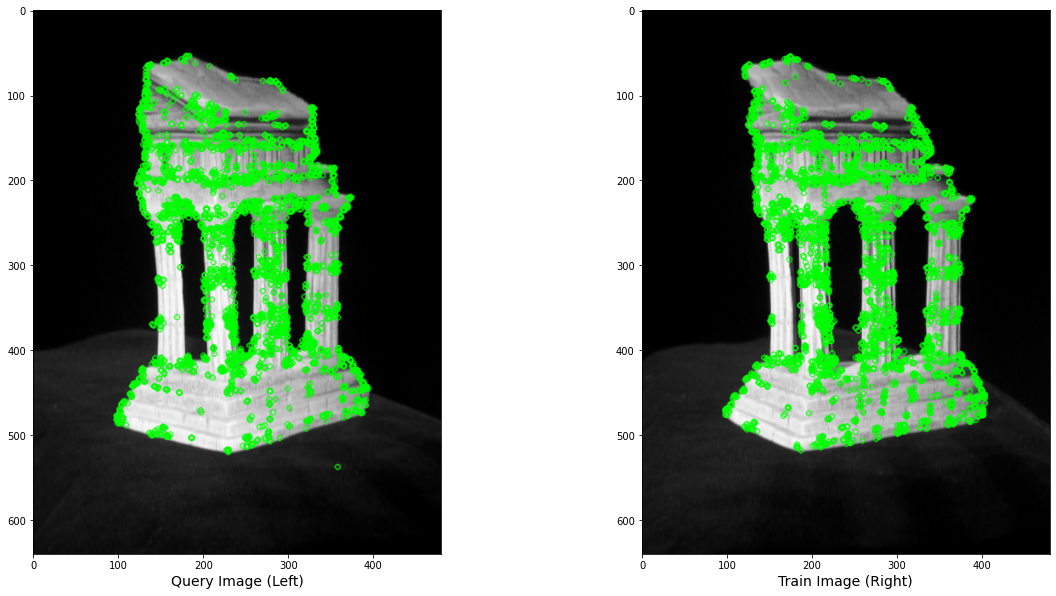

In [77]:
# Perform ORB feature detection
# Plot the features on the two images next to each other as subplots with the size of the entire figure as 20x10
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

kpsA, featuresA = detectAndDescribe(gray_img1, method=feature_extractor) # Query Image LEFT
kpsB, featuresB = detectAndDescribe(gray_img2, method=feature_extractor) # Query Image RIGHT


fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(gray_img1,kpsA,None,color=(0,255,0))) # Query Image LEFT
ax1.set_xlabel("Query Image (Left)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(gray_img2,kpsB,None,color=(0,255,0))) # Train Image RIGHT
ax2.set_xlabel("Train Image (Right)", fontsize=14)

plt.show()


Using: bf feature matcher
Raw matches (Brute force): 1408


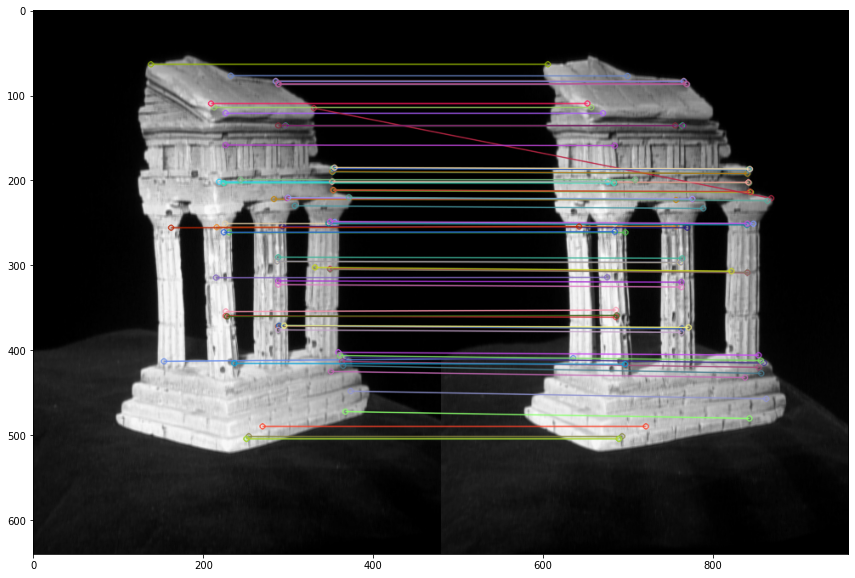

In [92]:
# Perform feature matching and extract only the top 72 matches
# Obtain the correspondences in terms of pixel locations in the left and right image. Name these correspondences as 'pts1' & 'pts2'
# Plot the matches on the two images next to each other as subplots with the size of the entire figure as 20x10

# Based on https://medium.com/@dc.aihub/3d-reconstruction-with-stereo-images-part-3-epipolar-geometry-98b75e40f59d
pts1tmp = []
pts2tmp = []
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,10))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(gray_img1,kpsA,gray_img2,kpsB,matches[:72], # Limits our matches to 72
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    for mat in matches[:72]:
      img1_idx = mat.queryIdx
      img2_idx = mat.trainIdx
      # x - col
      # y - rows
      # Get cords
      (x1, y1) = kpsA[img1_idx].pt
      (x2, y2) = kpsB[img2_idx].pt
      # Append to each list
      pts1tmp.append((x1, y1))
      pts2tmp.append((x2, y2))
    # Remove tuple value
    pts1 = [list(ele) for ele in pts1tmp] 
    pts2 = [list(ele) for ele in pts2tmp]
    # Make it shapeable
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)

elif feature_matching == 'knn':
    bf = createMatcher(feature_extractor, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []
    ratio = 0.75
    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
            pts2tmp.append(kpsB[m.trainIdx].pt)
            pts1tmp.append(kpsA[m.queryIdx].pt)
    # We've got all our results
    #https://www.geeksforgeeks.org/python-convert-list-of-tuples-to-list-of-list/
    pts1 = [list(ele) for ele in pts1tmp] 
    pts2 = [list(ele) for ele in pts2tmp]
    # Make it shapeable
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)
    img3 = cv2.drawMatches(gray_img1,kpsA,gray_img2,kpsB,np.random.choice(matches,500),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

#print("Our Pts1\n", pts1)
#print("Our Pts2\n", pts2)

In [137]:
# Load manually cleaned point correspondences for the temple stereo images
# CODE PROVIDED & COMMENTED
# pts1 & pts2 arrays to be used by the TA during grading

test = np.load(basePath+"temple_points.npz")
pts1 = test['pts1']
pts2 = test['pts2']

## Fundamental Matrix (F) using the 8-Point Algorithm
(40 points)

In [138]:
# Optmizations

def singularize(F):
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = U.dot(np.diag(S).dot(V))
    return F

def objective_F(f, pts1, pts2):
    F = singularize(f.reshape([3, 3]))
    num_points = pts1.shape[0]
    hpts1 = np.concatenate([pts1, np.ones([num_points, 1])], axis=1)
    hpts2 = np.concatenate([pts2, np.ones([num_points, 1])], axis=1)
    Fp1 = F.dot(hpts1.T)
    FTp2 = F.T.dot(hpts2.T)

    r = 0
    for fp1, fp2, hp2 in zip(Fp1.T, FTp2.T, hpts2):
        r += (hp2.dot(fp1))**2 * (1/(fp1[0]**2 + fp1[1]**2) + 1/(fp2[0]**2 + fp2[1]**2))
    return r

def refineF(F, pts1, pts2):
    f = scipy.optimize.fmin_powell(
        lambda x: objective_F(x, pts1, pts2), F.reshape([-1]),
        maxiter=100000,
        maxfun=10000
    )
    return singularize(f.reshape([3, 3]))

In [140]:
# Write a function for the 8-Point Algorithm.
# Input -- pts1, pts2, M (scale factor to normalize - max of the image width or height)
# Output -- Fundamental Matrix F

def eightpoint(pts1, pts2, M=1):
    '''
    Computes the fundamental matrix from corresponding points pts1, pts2 using
    the 8 point algorithm.
    '''
    T = np.array([[1.0/M, 0, 0],[0, 1.0/M, 0], [0,0,1.0]])
    
    #Normalize the coordinate and get x1, y1, x2, y2
    pts1 = pts1.astype(float)/M
    pts2 = pts2.astype(float)/M
    
    x1 = pts1[:,0]
    y1 = pts1[:,1]
    x2 = pts2[:,0]
    y2 = pts2[:,1]
    

    #Get A matrix
    N = x1.shape[0]
    A = np.ones((N, 9)).astype(float)
    A[:, 0] = (x2*x1).T
    A[:, 1] = (x2*y1).T
    A[:, 2] = x2.T
    A[:, 3] = (y2*x1).T
    A[:, 4] = (y2*y1).T
    A[:, 5] = y2.T
    A[:, 6] = x1.T
    A[:, 7] = y1.T

    #Get F from the SVD decomposition
    _, _, Vt = np.linalg.svd(A)
    F = Vt[-1,:].reshape(3,3)

    #Refine & singularize F
    F = refineF(F, pts1, pts2)

    #unscale F
    F = np.dot(T.T, F).dot(T)
    
    return F


In [141]:
# Call the above created function for the 8-Point Algorithm
# Store and print the returned Fundamental Matrix F
F = eightpoint(pts1, pts2)
print(F)

Optimization terminated successfully.
         Current function value: 44.538231
         Iterations: 18
         Function evaluations: 2541
[[ 4.66791796e-07 -8.37849716e-06 -2.06685000e-03]
 [-1.73678007e-05 -2.40055697e-07  1.51547457e-01]
 [ 4.05861671e-03 -1.45455724e-01 -5.97918281e-01]]


## Intrinsic Matrices K-1 & K-2

In [142]:
# Load the intrinsic matrices -- CODE PROVIDED
intrinsics = np.load(basePath+"intrinsics.npz")
K1, K2 = intrinsics['K1'], intrinsics['K2']
print(K1)
print(K2)

[[1.5204e+03 0.0000e+00 3.0232e+02]
 [0.0000e+00 1.5259e+03 2.4687e+02]
 [0.0000e+00 0.0000e+00 1.0000e+00]]
[[1.5204e+03 0.0000e+00 3.0232e+02]
 [0.0000e+00 1.5259e+03 2.4687e+02]
 [0.0000e+00 0.0000e+00 1.0000e+00]]


## Estimate Essential Matrix (E)
(5 points)

In [143]:
# Write a function to estimate the essential matrix
# Input -- F, K1, K2
# Output -- E
def essentialMatrix(F, K1, K2):
    E = K2.T.dot(F).dot(K1)
    return E

In [144]:
# Call the above created function
# Store and print the returned Essential Matrix E
E = essentialMatrix(F,K1,K2)
print(E)

[[ 1.07904346e+00 -1.94379321e+01 -6.07267387e+00]
 [-4.02929217e+01 -5.58938678e-01  2.23143895e+02]
 [-1.33569796e-01 -2.25906403e+02 -3.85410073e-01]]


## Camera-1 Projection
(5 points)

In [145]:
# extr1 = [R | T] with R = I and T = 0-> 3x4
# extr1 -> rotation (R1) = Identity, translation (T1) = zero. 
# Use extr1 and K1 to obtain the projection matrix of the first camera (P1).
# Compute and print the projection matrix of the first camera (P1) using K1 and ext1 -> 3x4
P1 = K1 @ np.hstack([np.eye(3),np.zeros((3,1))])
print(P1)

[[1.5204e+03 0.0000e+00 3.0232e+02 0.0000e+00]
 [0.0000e+00 1.5259e+03 2.4687e+02 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00]]


## Triangulation
(40 points)

In [146]:
# Write a function to perform triangulation
# Input: P1 - camera-1 projection matrix -> 3x4
#        P2 - camera-2 projection matrix -> 3x4
#        pts1 - points from image-1 -> Nx2
#        pts2 - corresponding points from image-2 -> Nx2
# Output: pts3D - triangulated 3D points -> Nx3
def triangulate(P1, P2, pts1, pts2):
    # REPLACE with your implementation

    # Compute the 3D point for each point correspondence by doing the following:
    #     Create the array A consisting of 2 rows each from corresponding points from pts1 and pts2
    #     Perform SVD of 'A' to obtain the 3D point 'X'
    #     Normailze the points to a scale and append to the list of triangulated 3D points
    # Convert homogeneous 3D points to be heterogeneous 3D points
    x1 = pts1[:,0]
    y1 = pts1[:,1]

    x2 = pts2[:,0]
    y2 = pts2[:,1]
    
    # create A matrix (described in more detail in writeup)
    A1 = np.vstack((P1[2,0]*x1 - P1[0,0], P1[2,1]*x1 - P1[0,1], P1[2,2]*x1 - P1[0,2], P1[2,3]*x1 - P1[0,3])).T
    A2 = np.vstack((P1[2,0]*y1 - P1[1,0], P1[2,1]*y1 - P1[1,1], P1[2,2]*y1 - P1[1,2], P1[2,3]*y1 - P1[1,3])).T
    A3 = np.vstack((P2[2,0]*x2 - P2[0,0], P2[2,1]*x2 - P2[0,1], P2[2,2]*x2 - P2[0,2], P2[2,3]*x2 - P2[0,3])).T
    A4 = np.vstack((P2[2,0]*y2 - P2[1,0], P2[2,1]*y2 - P2[1,1], P2[2,2]*y2 - P2[1,2], P2[2,3]*y2 - P2[1,3])).T
    
    pts3D = list()
    for i in range(pts1.shape[0]):
        # grab rows of A matrix needed for i-th point
        A = np.vstack((A1[i],A2[i],A3[i],A4[i]))
        
        # 3D point in homogeneous coordinates is the last row of V_T
        U,S,V_T = np.linalg.svd(A)
        p_temp = V_T[-1,:]
        p_temp = p_temp / p_temp[-1]
        pts3D.append(p_temp)
        
    pts3D = np.vstack(pts3D)
    
    # delete last column of pts3D, making it of the form N X 3 (x, y, z)
    pts3D = pts3D[:,:-1]

    return pts3D

## Camera-2 Projection
(20 points)

In [147]:
# Function to obtain the 4 possibilities for the camera-2 extrinsic matrix (extr2) -- CODE PROVIDED
# Input -- Essential Matrix E
# Ouput -- extr2

def camera2(E):
    U,S,V = np.linalg.svd(E)
    m = S[:2].mean()
    E = U.dot(np.array([[m,0,0], [0,m,0], [0,0,0]])).dot(V)
    U,S,V = np.linalg.svd(E)
    W = np.array([[0,-1,0], [1,0,0], [0,0,1]])

    if np.linalg.det(U.dot(W).dot(V))<0:
        W = -W

    extr2s = np.zeros([3,4,4])
    extr2s[:,:,0] = np.concatenate([U.dot(W).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    extr2s[:,:,1] = np.concatenate([U.dot(W).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    extr2s[:,:,2] = np.concatenate([U.dot(W.T).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    extr2s[:,:,3] = np.concatenate([U.dot(W.T).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)

    return extr2s

In [148]:
# Call the above function to obtain the 4 possibilities for extr2 -- CODE PROVIDED
extr2s = camera2(E)
print(extr2s)

[[[ 9.64847502e-01  9.64847502e-01  9.95354182e-01  9.95354182e-01]
  [-2.80105822e-02 -2.80105822e-02  2.62477338e-02  2.62477338e-02]
  [ 2.61313424e-01  2.61313424e-01  9.26342725e-02  9.26342725e-02]
  [-1.00000000e+00  1.00000000e+00 -1.00000000e+00  1.00000000e+00]]

 [[ 2.68325365e-02  2.68325365e-02  2.62211676e-02  2.62211676e-02]
  [ 9.99607322e-01  9.99607322e-01 -9.99655035e-01 -9.99655035e-01]
  [ 8.07565568e-03  8.07565568e-03  1.50409140e-03  1.50409140e-03]
  [-2.70654313e-02  2.70654313e-02 -2.70654313e-02  2.70654313e-02]]

 [[-2.61437016e-01 -2.61437016e-01  9.26417958e-02  9.26417958e-02]
  [-7.80074208e-04 -7.80074208e-04  9.31875112e-04  9.31875112e-04]
  [ 9.65220223e-01  9.65220223e-01 -9.95699066e-01 -9.95699066e-01]
  [ 8.61111496e-02 -8.61111496e-02  8.61111496e-02 -8.61111496e-02]]]


In [130]:
# Use the 'triangulate' function to figure out the correct value for extr2 from the 4 possibilities obtained above
# For each possibility:
#     Compute P2 using K2 and extr2
#     Use this P2 to triangulate and obtain the 3D points
# The extr2 for which all the triangulated 3D points are in front of both cameras (i.e., z > 0) is the correct extr2
# REPLACE with your implementation

# extr2s has the shape of [4,4,3] so be careful
min_err = -1 
for i in range(4):
  test_extr2 = extr2s[:,:,i]
  test_P2 = np.matmul(K2, test_extr2)
  test_P = triangulate(P1,test_P2, pts1, pts2)
  # if the minimum z position is positive, that means that this solution
  # for M2 gives a 3d point that is in front of both cameras, so we've found
  # our solution
  print(np.min(test_P[:,2]))
  if np.min(test_P[:,2]) > 0:
    print("We've made it")
    extr2 = test_extr2
    P2 = test_P2
    P = test_P

2.0973363356305312
We've made it
-8.232637209047867
-759.3610836526725
-661.6652830682154


In [131]:
# Print the final correct extr2 and the corresponding P2 -- CODE PROVIDED
print(extr2)
print(P2)

[[ 9.64847502e-01 -2.80105822e-02  2.61313424e-01 -1.00000000e+00]
 [ 2.68325365e-02  9.99607322e-01  8.07565568e-03 -2.70654313e-02]
 [-2.61437016e-01 -7.80074208e-04  9.65220223e-01  8.61111496e-02]]
[[ 1.38791650e+03 -4.28231212e+01  6.89106308e+02 -1.49436688e+03]
 [-2.35971887e+01  1.52510824e+03  2.50606559e+02 -2.00408822e+01]
 [-2.61437016e-01 -7.80074208e-04  9.65220223e-01  8.61111496e-02]]


## Projection Matrix Decomposition
(5 points)

In [149]:
# Call the cv2.decomposeProjectionMatrix() function to decompose the projections matrices (P1 & P2) to obtain K, R, T separately for each of them
# Print all 6 - K1 (3x3), K2 (3x3), R1 (3x3), R2 (3x3), T1 (3x1), T2 (3x1)
print("Our P2")
cv2.decomposeProjectionMatrix(P2)

Our P2


(array([[ 1.52040000e+03, -2.34479103e-13,  3.02320000e+02],
        [ 0.00000000e+00,  1.52590000e+03,  2.46870000e+02],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 9.64847502e-01, -2.80105822e-02,  2.61313424e-01],
        [ 2.68325365e-02,  9.99607322e-01,  8.07565568e-03],
        [-2.61437016e-01, -7.80074208e-04,  9.65220223e-01]]),
 array([[-6.97263753e-01],
        [ 6.27063184e-04],
        [-1.25902810e-01],
        [-7.05670849e-01]]),
 array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  9.99999673e-01, -8.08182356e-04],
        [ 0.00000000e+00,  8.08182356e-04,  9.99999673e-01]]),
 array([[ 0.96522054,  0.        , -0.26143702],
        [ 0.        ,  1.        ,  0.        ],
        [ 0.26143702,  0.        ,  0.96522054]]),
 array([[ 0.99961352,  0.02779938,  0.        ],
        [-0.02779938,  0.99961352,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[-0.04630544],
        [15.15

## 3D Reconstruction
(10 points)

In [150]:
# Perform Sparse 3D Reconstruction
# Call the 'triangulate' function using the final camera projection matrices (P1 & P2) and the points (pts1 & pts2) to obtain the final set of 3D points (pts3D)
# Use plotly.express to plot an interactable 3D Scatter Plot for the 3D points (pts3D)
def visualize_3d(P):
    x, y, z = P[:,0], P[:,1], P[:,2]
    #print("Our x ", x)
    #print("Our y ", y)
    #print("Our z ", z)
    df = {'x': x, 'y': y, 'z': z}
    fig = px.scatter_3d(df, x="x", y="y", z="z")
    fig.show()

visualize_3d(P)

## Reprojection Error
(20 points)

In [151]:
# Write a function to perform triangulation and obtain the reprojection error
# Input: P1 - camera-1 projection matrix -> 3x4
#        P2 - camera-2 projection matrix -> 3x4
#        pts1 - points from image-1 -> Nx2
#        pts2 - corresponding points from image-2 -> Nx2
# Output: reprojection_error -> average Eucildean error of reprojection
def reprojection_error(P1, P2, pts1, pts2):
    # Replace pass by your implementation
    n = pts1.shape[0]
    x1 = pts1[:,0]
    x2 = pts2[:,0]
    y1 = pts1[:,1]
    y2 = pts2[:,1]

    # initialize values
    err = 0

    for i in range(n):
        A = np.array([x1[i]*P1[2,:] - P1[0,:],
                      y1[i]*P1[2,:] - P1[1,:],
                      x2[i]*P2[2,:] - P2[0,:],
                      y2[i]*P2[2,:] - P2[1,:]])

        V = np.linalg.svd(A)[2]
        p = V[-1,:]
        p = np.divide(p,p[3])

        proj1 = np.dot(P1, p)
        proj2 = np.dot(P2, p)
        err1 = np.linalg.norm(proj1[:2]/proj1[-1] - pts1[i])**2
        err2 = np.linalg.norm(proj2[:2]/proj2[-1] - pts2[i])**2
        err += err1 + err2

    #print(err)
    return err

In [152]:
# Call the above functin to obtain and print the reprojection error for the ORB features points 'pts1' and 'pts2' -- CODE PROVIDED
#print(p1)
print(reprojection_error(P1, P2, pts1, pts2))

169.84416753767746


#Submission Instructions



1.   Complete all tasks above
2.   Export this notebook as .ipynb
      (File > Download as ipynb)
3.   Upload the .ipynb file on Blackboard - **file MUST contain the output for ALL cells**


##Rubric

*   (20 points) Sparse feature point correspondence
*   (40 points) Fundamental Matrix (F) using the 8-Point Algorithm
*   (05 points) Estimate Essential Matrix (E)
*   (05 points) Camera-1 Projection
*   (40 points) Triangulation
*   (20 points) Camera-2 Projection
*   (05 points) Projection Matrix Decomposition
*   (10 points) 3D Reconstruction
*   (20 points) Reprojection Error